In [4]:
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

from IPython.display import clear_output
from datetime import datetime

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, train_test_split

%matplotlib inline
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.5)
sns.set_style('ticks')

from os import listdir
from os.path import isfile, join
import os
#os.getcwd()
os.chdir('/Users/Grant/Documents/Model Risk Mgmt/MRM-Project')
import warnings
warnings.filterwarnings('ignore')


In [5]:
os.getcwd()
#os.chdir('/Users/Grant/Documents/Model Risk Mgmt/MRM-Project')

'/Users/Grant/Documents/Model Risk Mgmt/MRM-Project'

In [6]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
import pandas as pd

In [7]:
# Save model dataframe to a pickle file for easier reading
#model_df.to_pickle('model_df.pkl')
model_df = pd.read_pickle('model_df.pkl')

In [8]:
model_df.fully_paid.value_counts()

1    112445
0     28465
Name: fully_paid, dtype: int64

### Downsampling the data to have an even distribution of the target

In [9]:
from sklearn.utils import resample
majority_class = model_df[model_df['fully_paid'] == 1]
minority_class = model_df[model_df['fully_paid'] == 0]

# Downsample majority class
majority_downsampled = resample(
    majority_class,
    replace=False,
    n_samples=len(minority_class),
    random_state=42 
)

downsampled_model_df = pd.concat([majority_downsampled, minority_class])
downsampled_model_df = downsampled_model_df.sample(frac=1, random_state=42).reset_index(drop=True)
downsampled_model_df.fully_paid.value_counts()

1    28465
0    28465
Name: fully_paid, dtype: int64

In [10]:
# Save model dataframe to a pickle file for easier reading
downsampled_model_df.to_pickle('downsampled_model_df.pkl')
#downsampled_model_df = pd.read_pickle('downsampled_model_df.pkl')

In [31]:
X = downsampled_model_df.drop(columns = ['grade','sub_grade','fully_paid','installment','int_rate','zip_code','issue_d'])
y = downsampled_model_df['fully_paid']

In [32]:
X_train, X_test, y_train, y_test = train_test_split(
    X,y, test_size=0.25, random_state=4, stratify=y)

In [140]:
import optuna
import lightgbm as lgb
import sklearn.metrics

from sklearn.model_selection import train_test_split

# FYI: Objective functions can take additional arguments
# (https://optuna.readthedocs.io/en/stable/faq.html#objective-func-additional-args).
def objective(trial):
    data, target = X,y
    train_x, valid_x, train_y, valid_y = train_test_split(data, target, test_size=0.25, stratify=target, random_state=42)
    dtrain = lgb.Dataset(train_x, label=train_y)

    param = {
        "objective": "binary",
        "metric": "binary_logloss",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
    }
    
    gbm = lgb.train(param, dtrain)
    preds = gbm.predict(valid_x)
    pred_labels = np.rint(preds)
    accuracy = sklearn.metrics.accuracy_score(valid_y, pred_labels)
    recall = sklearn.metrics.recall_score(valid_y, pred_labels)
    return accuracy, recall

In [20]:
study = optuna.create_study(directions=['maximize','maximize'])
study.optimize(objective, n_trials=100)

[I 2024-11-20 15:03:30,123] A new study created in memory with name: no-name-1b30337e-4093-4903-b533-6c59e7e73d5c
[I 2024-11-20 15:03:32,367] Trial 0 finished with values: [0.9014262629101384, 0.886593591905565] and parameters: {'lambda_l1': 2.8937850793405136e-05, 'lambda_l2': 7.138371464855999, 'num_leaves': 195, 'feature_fraction': 0.939373002660556, 'bagging_fraction': 0.8788187752025273, 'bagging_freq': 4, 'min_child_samples': 35}.
[I 2024-11-20 15:03:33,910] Trial 1 finished with values: [0.9021288554767091, 0.8896852164137156] and parameters: {'lambda_l1': 3.563893615151643, 'lambda_l2': 1.2951987172985615e-06, 'num_leaves': 224, 'feature_fraction': 0.7318127011886233, 'bagging_fraction': 0.8300080338708786, 'bagging_freq': 6, 'min_child_samples': 36}.
[I 2024-11-20 15:03:35,369] Trial 2 finished with values: [0.9017775591934237, 0.8875772906127037] and parameters: {'lambda_l1': 1.6314552873451717e-07, 'lambda_l2': 6.422840276238028e-08, 'num_leaves': 137, 'feature_fraction': 0.

In [21]:
study.best_trials

[FrozenTrial(number=43, state=TrialState.COMPLETE, values=[0.904166373919764, 0.8909499718943227], datetime_start=datetime.datetime(2024, 11, 20, 15, 4, 27, 229539), datetime_complete=datetime.datetime(2024, 11, 20, 15, 4, 28, 743860), params={'lambda_l1': 8.049759873539534, 'lambda_l2': 3.368738134527936e-08, 'num_leaves': 158, 'feature_fraction': 0.7302290808057998, 'bagging_fraction': 0.7559311830611393, 'bagging_freq': 5, 'min_child_samples': 94}, user_attrs={}, system_attrs={'nsga2:generation': 0}, intermediate_values={}, distributions={'lambda_l1': FloatDistribution(high=10.0, log=True, low=1e-08, step=None), 'lambda_l2': FloatDistribution(high=10.0, log=True, low=1e-08, step=None), 'num_leaves': IntDistribution(high=256, log=False, low=2, step=1), 'feature_fraction': FloatDistribution(high=1.0, log=False, low=0.4, step=None), 'bagging_fraction': FloatDistribution(high=1.0, log=False, low=0.4, step=None), 'bagging_freq': IntDistribution(high=7, log=False, low=1, step=1), 'min_chi

## The params below were pulled from trials from a previous study

Training accuracy 0.8450
Testing accuracy 0.7955


<AxesSubplot:title={'center':'Metric during training'}, xlabel='Iterations', ylabel='binary_logloss'>

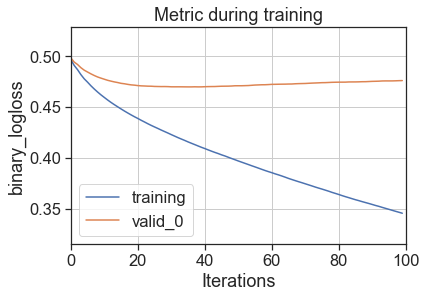

In [192]:
lgbm = lgb.LGBMClassifier(lambda_l1= 2.1422382641914777e-07,
    lambda_l2= 2.2658200484886442e-07,
    num_leaves= 208,
    feature_fraction= 0.8887401691714417,
    bagging_fraction= 0.6009100730937127,
    bagging_freq= 3,
    min_child_samples= 96)
lgbm.fit(X_train, y_train, eval_set=[(X_test,y_test),(X_train,y_train)])
print('Training accuracy {:.4f}'.format(lgbm.score(X_train,y_train)))
print('Testing accuracy {:.4f}'.format(lgbm.score(X_test,y_test)))
lgb.plot_metric(lgbm)

Training accuracy 0.8001
Testing accuracy 0.7988


<AxesSubplot:title={'center':'Metric during training'}, xlabel='Iterations', ylabel='binary_logloss'>

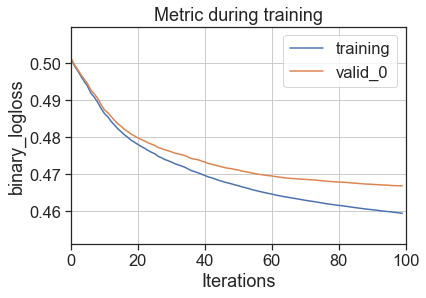

In [193]:
lgbm2 = lgb.LGBMClassifier(lambda_l1= 2.223364546834443,
    lambda_l2= 1.649432904280486,
    num_leaves= 11,
    feature_fraction= 0.5306603476323929,
    bagging_fraction= 0.8729028811929775,
    bagging_freq= 2,
    min_child_samples= 69)
lgbm2.fit(X_train, y_train, eval_set=[(X_test,y_test),(X_train,y_train)])
print('Training accuracy {:.4f}'.format(lgbm2.score(X_train,y_train)))
print('Testing accuracy {:.4f}'.format(lgbm2.score(X_test,y_test)))
lgb.plot_metric(lgbm2)

In [51]:
os.getcwd()

'/Users/Grant/Documents/Model Risk Mgmt/MRM-Project'

### Trying it out with the unbalanced dataset and dropping some of the features

In [194]:
X = model_df.drop(columns = ['term','term_ 60 months','emp_length_10+ years','emp_length_2-4 years',
'emp_length_5-9 years','fico_range_high','fico_range_low','home_ownership_MORTGAGE','home_ownership_NONE',
'home_ownership_OTHER','home_ownership_OWN','home_ownership_RENT','sec_app_fico_range_high',
'sec_app_fico_range_low','grade','sub_grade','fully_paid','installment','int_rate','zip_code','issue_d',
'year','last_fico_range_high','last_fico_range_low','purpose_credit_card','purpose_debt_consolidation',
'purpose_educational','purpose_home_improvement','purpose_house','purpose_major_purchase','purpose_medical',
'purpose_moving','purpose_other','purpose_renewable_energy','purpose_small_business','purpose_vacation','purpose_wedding','application_type_Joint App',
'verification_status_Source Verified','verification_status_Verified','addr_state','application_type','pub_rec','tax_liens',
'pub_rec_bankruptcies','num_op_rev_tl','num_sats','total_bal_ex_mort','mo_sin_rcnt_rev_tl_op','mths_since_recent_revol_delinq','tot_coll_amt','pct_tl_nvr_dlq','num_rev_accts',
'num_bc_tl','inq_last_6mths','num_bc_sats','open_acc'])
y = model_df['fully_paid']

In [195]:
X_train, X_test, y_train, y_test = train_test_split(
    X,y, test_size=0.25, random_state=4, stratify=y)

### These params were found from a previous study, but they worked well. First model below shows pretty strong overfitting, suggesting we go with this one to be one of our flaws. Second model performs better and minimizes changes in train/test accuracy(better fitting model): this should be the "correct" model. Maybe make this flaw be the undocumented flaw? Have FICO being in the model should be the documented flaw

Training accuracy 0.8450
Testing accuracy 0.7955


<AxesSubplot:title={'center':'Metric during training'}, xlabel='Iterations', ylabel='binary_logloss'>

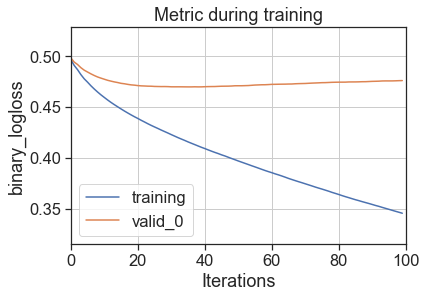

In [196]:
lgbm = lgb.LGBMClassifier(lambda_l1= 2.1422382641914777e-07,
    lambda_l2= 2.2658200484886442e-07,
    num_leaves= 208,
    feature_fraction= 0.8887401691714417,
    bagging_fraction= 0.6009100730937127,
    bagging_freq= 3,
    min_child_samples= 96)
lgbm.fit(X_train, y_train, eval_set=[(X_test,y_test),(X_train,y_train)])
print('Training accuracy {:.4f}'.format(lgbm.score(X_train,y_train)))
print('Testing accuracy {:.4f}'.format(lgbm.score(X_test,y_test)))
lgb.plot_metric(lgbm)

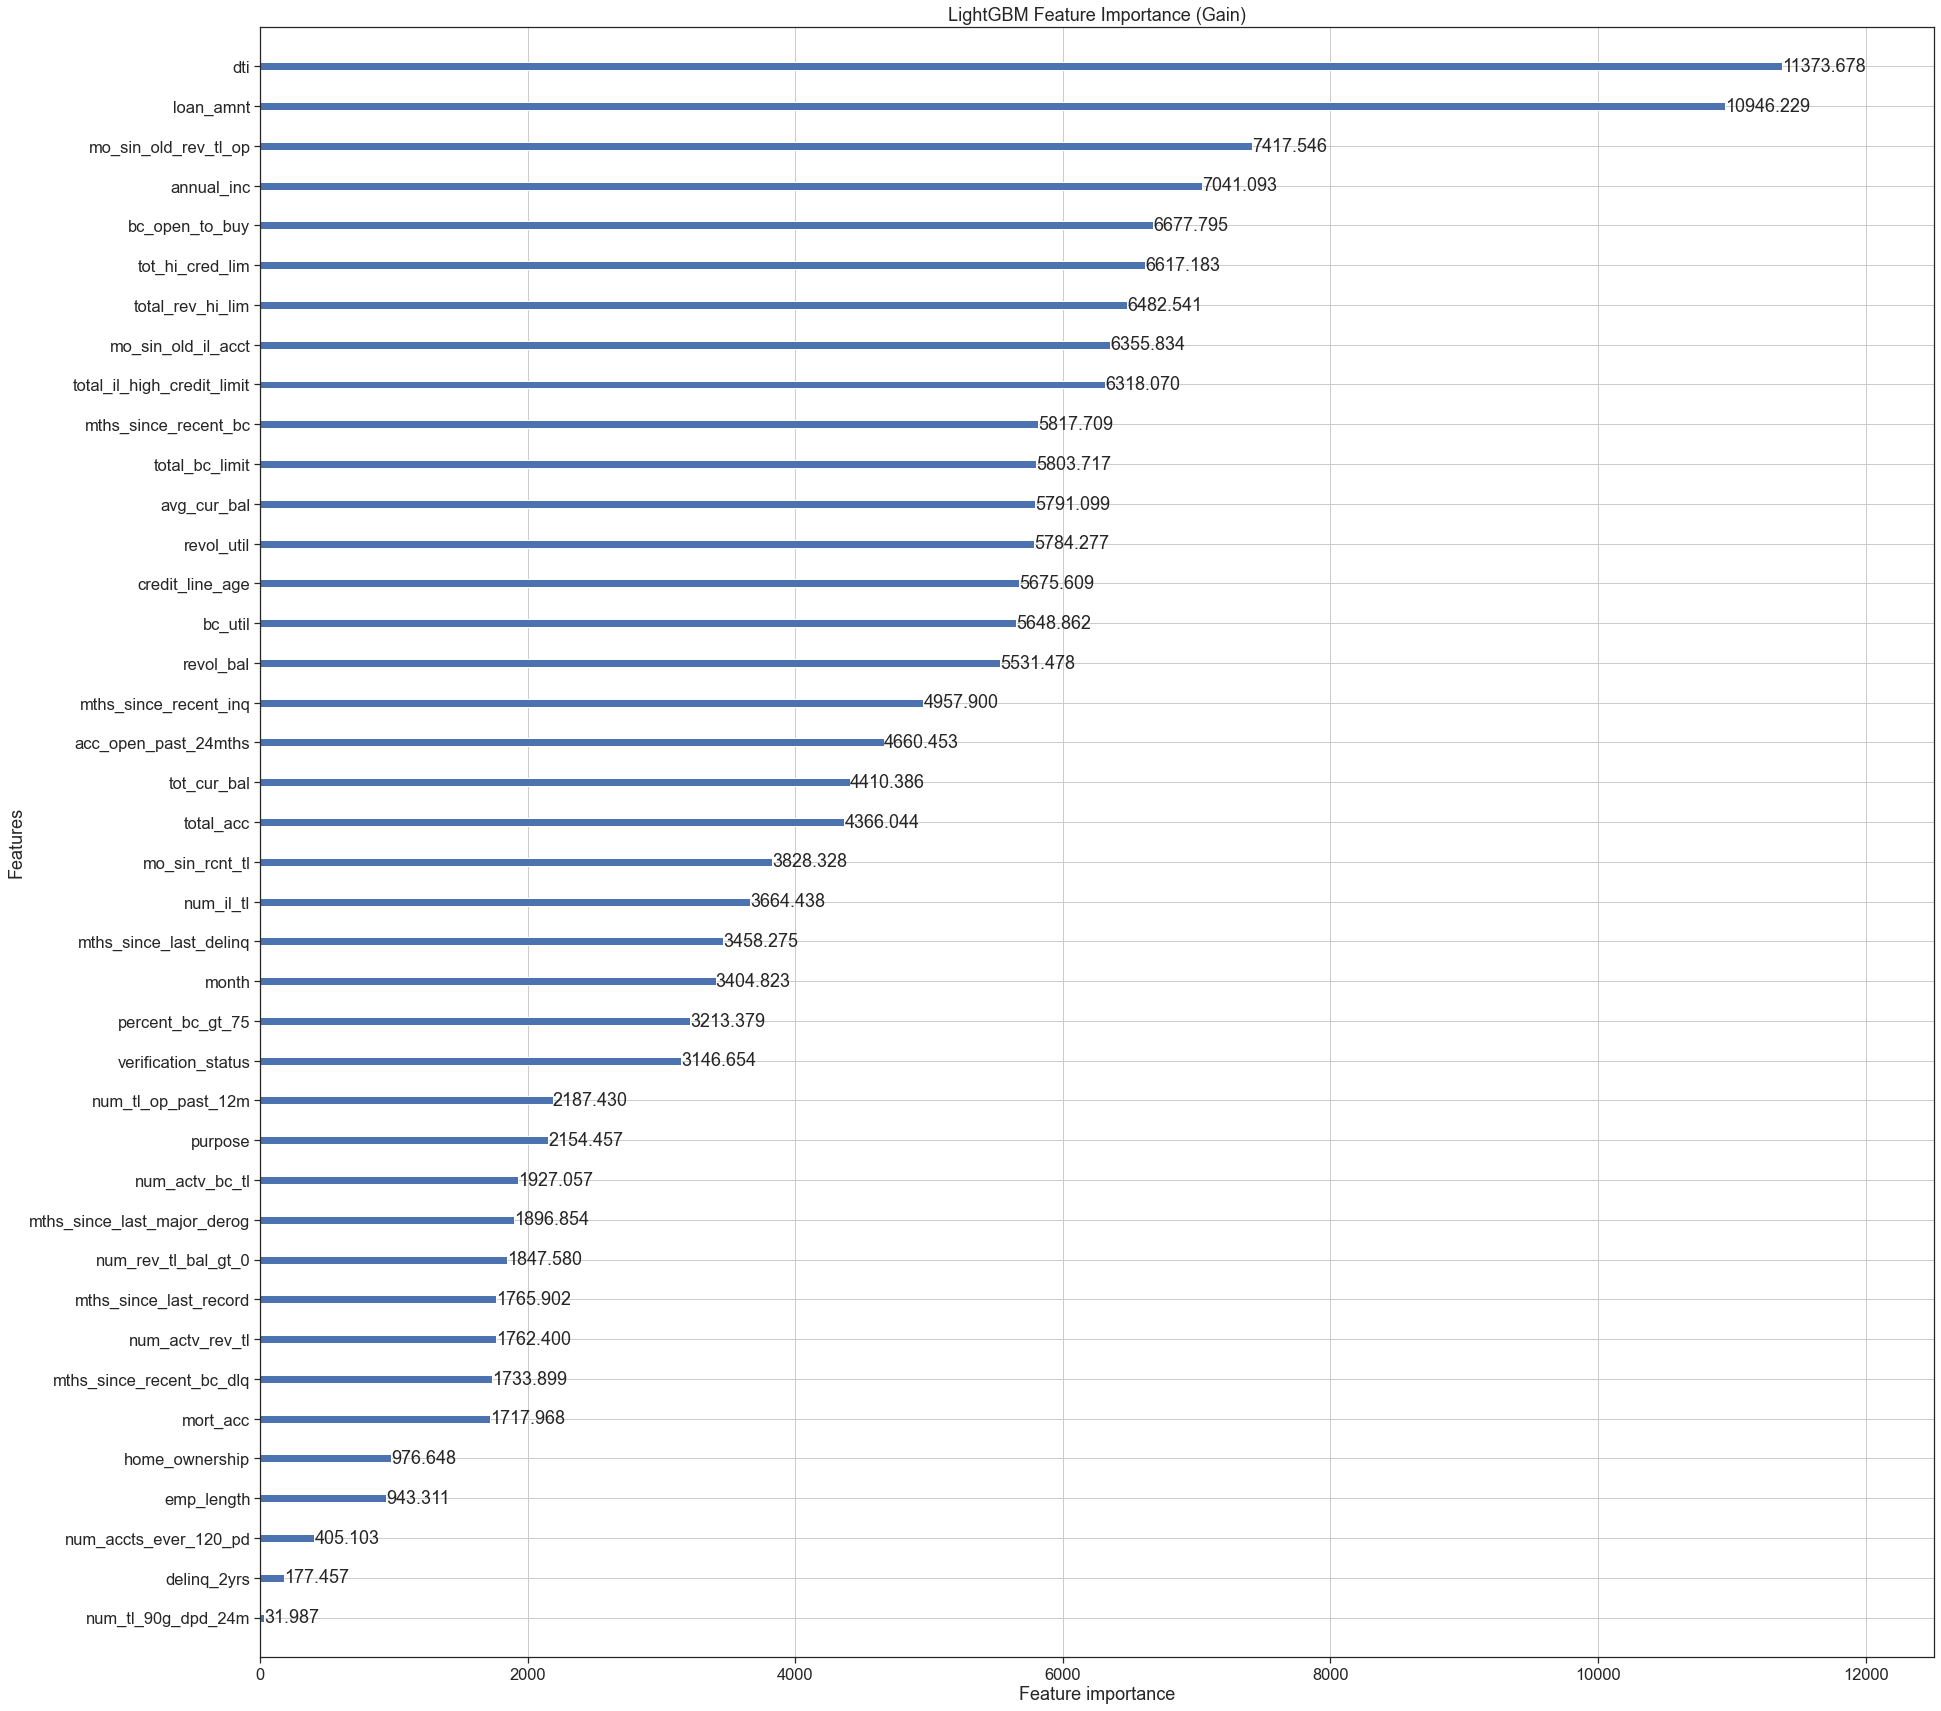

In [197]:
lgb.plot_importance(lgbm, importance_type="gain", figsize=(30,30), title="LightGBM Feature Importance (Gain)")
plt.show()

Training accuracy 0.8001
Testing accuracy 0.7988


<AxesSubplot:title={'center':'Metric during training'}, xlabel='Iterations', ylabel='binary_logloss'>

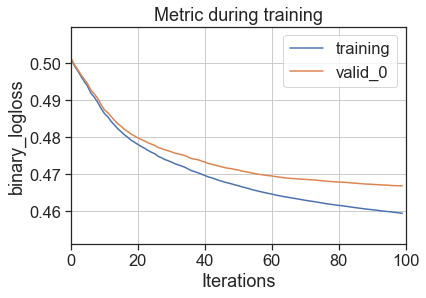

In [190]:
lgbm2 = lgb.LGBMClassifier(lambda_l1= 2.223364546834443,
    lambda_l2= 1.649432904280486,
    num_leaves= 11,
    feature_fraction= 0.5306603476323929,
    bagging_fraction= 0.8729028811929775,
    bagging_freq= 2,
    min_child_samples= 69)
lgbm2.fit(X_train, y_train, eval_set=[(X_test,y_test),(X_train,y_train)])
print('Training accuracy {:.4f}'.format(lgbm2.score(X_train,y_train)))
print('Testing accuracy {:.4f}'.format(lgbm2.score(X_test,y_test)))
lgb.plot_metric(lgbm2)

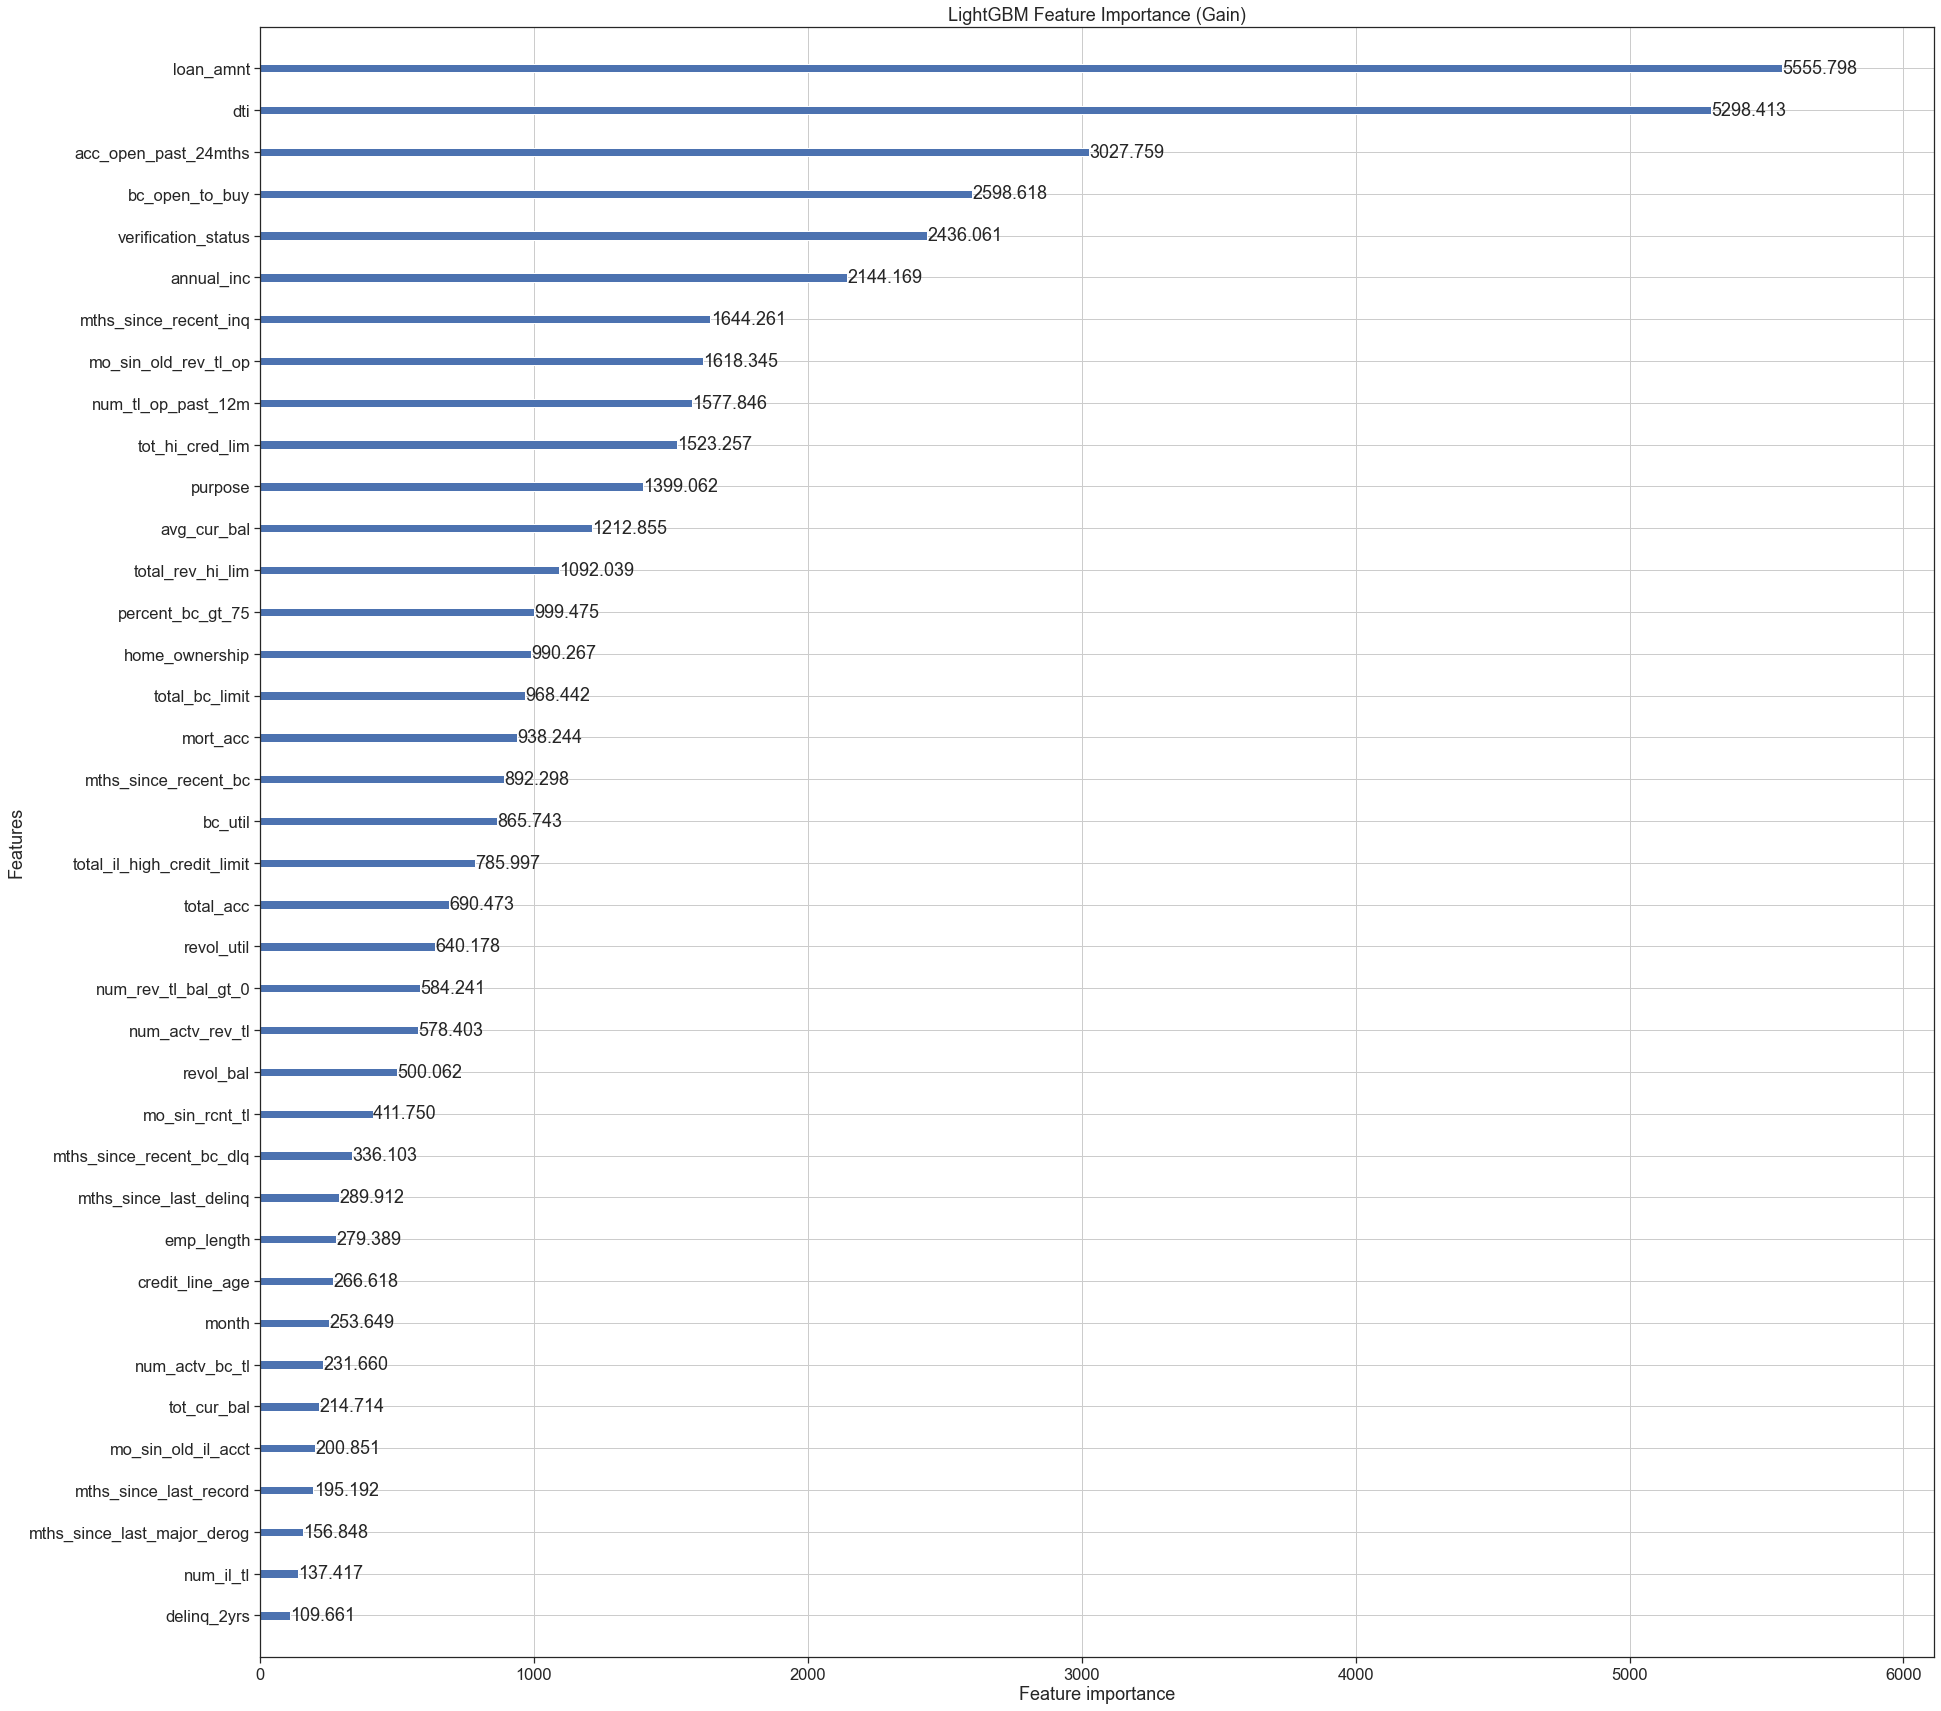

In [198]:
lgb.plot_importance(lgbm2, importance_type="gain", figsize=(30,30), title="LightGBM Feature Importance (Gain)")
plt.show()

In [187]:
X_train.shape

(105682, 45)

In [170]:
sorted(X_train.columns)

['acc_now_delinq',
 'acc_open_past_24mths',
 'annual_inc',
 'avg_cur_bal',
 'bc_open_to_buy',
 'bc_util',
 'chargeoff_within_12_mths',
 'collections_12_mths_ex_med',
 'credit_line_age',
 'delinq_2yrs',
 'delinq_amnt',
 'dti',
 'emp_length',
 'home_ownership',
 'inq_last_6mths',
 'loan_amnt',
 'mo_sin_old_il_acct',
 'mo_sin_old_rev_tl_op',
 'mo_sin_rcnt_rev_tl_op',
 'mo_sin_rcnt_tl',
 'month',
 'mort_acc',
 'mths_since_last_delinq',
 'mths_since_last_major_derog',
 'mths_since_last_record',
 'mths_since_recent_bc',
 'mths_since_recent_bc_dlq',
 'mths_since_recent_inq',
 'mths_since_recent_revol_delinq',
 'num_accts_ever_120_pd',
 'num_actv_bc_tl',
 'num_actv_rev_tl',
 'num_bc_sats',
 'num_bc_tl',
 'num_il_tl',
 'num_op_rev_tl',
 'num_rev_accts',
 'num_rev_tl_bal_gt_0',
 'num_sats',
 'num_tl_90g_dpd_24m',
 'num_tl_op_past_12m',
 'open_acc',
 'pct_tl_nvr_dlq',
 'percent_bc_gt_75',
 'purpose',
 'revol_bal',
 'revol_util',
 'term',
 'tot_coll_amt',
 'tot_cur_bal',
 'tot_hi_cred_lim',
 'tota

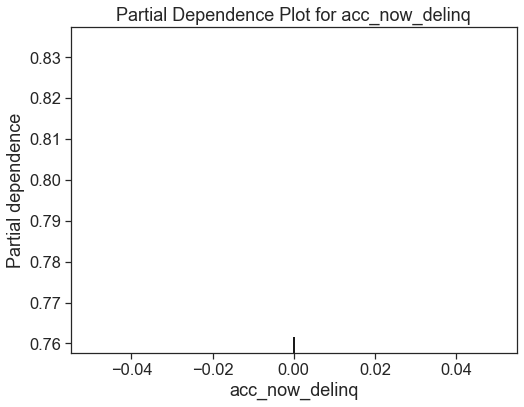

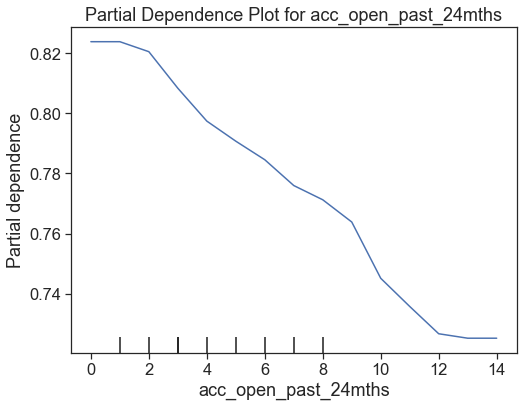

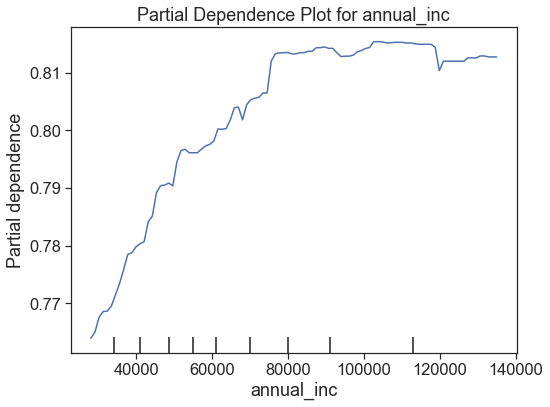

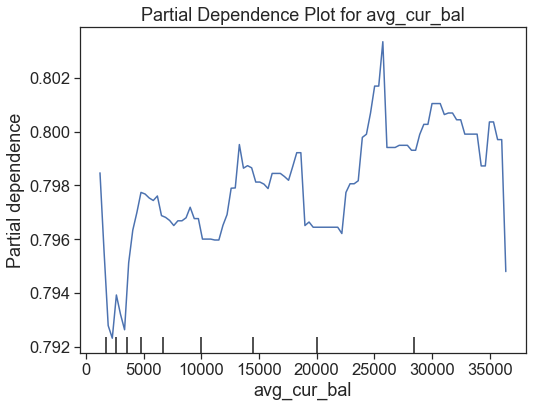

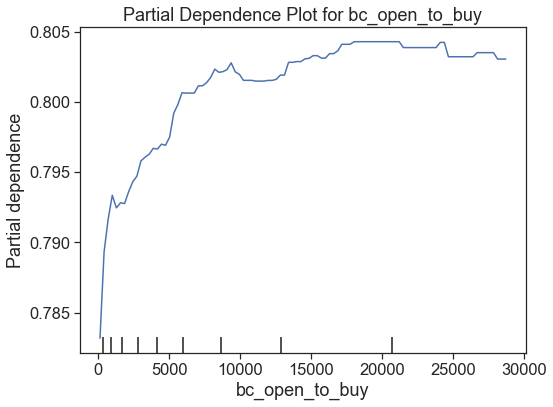

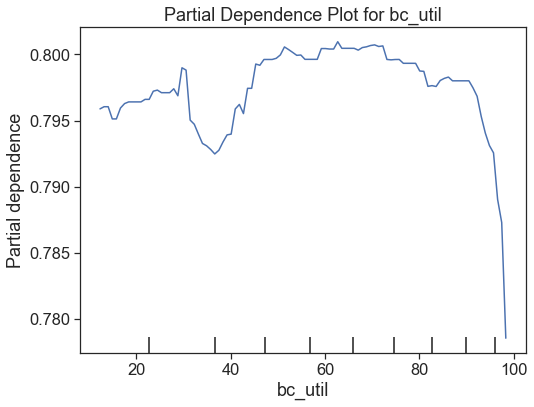

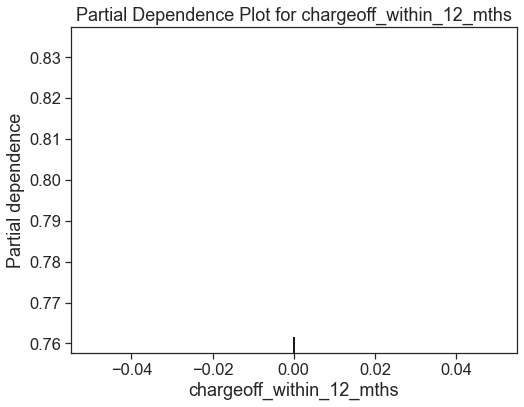

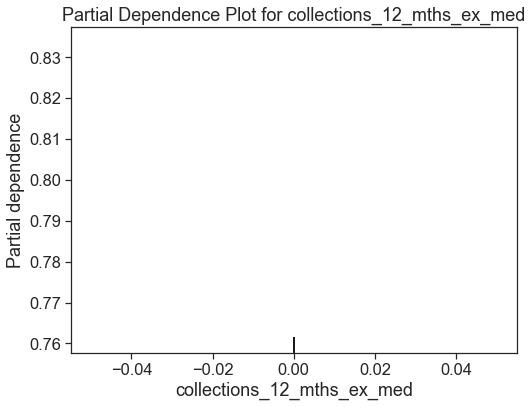

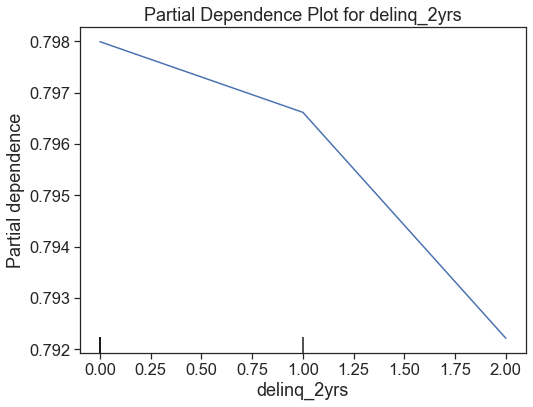

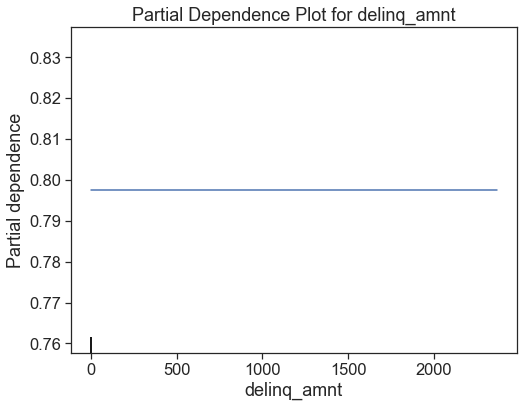

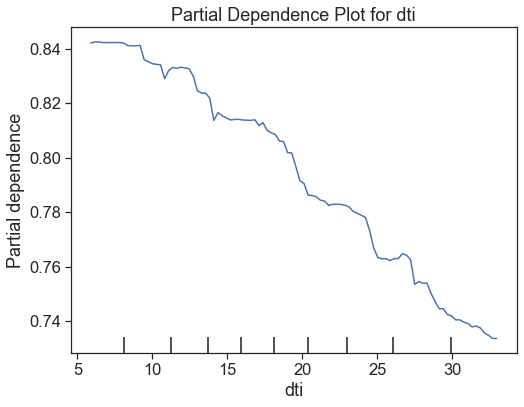

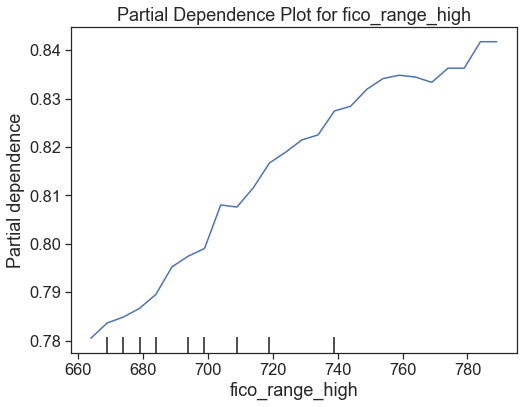

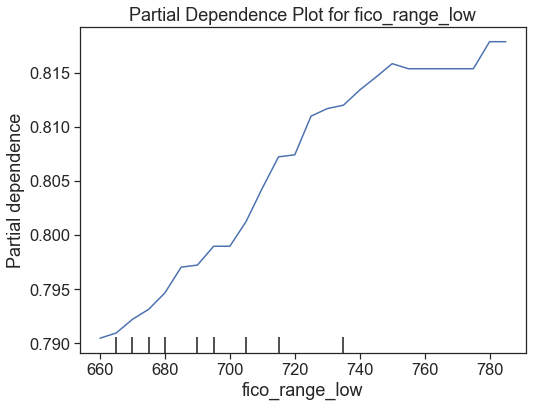

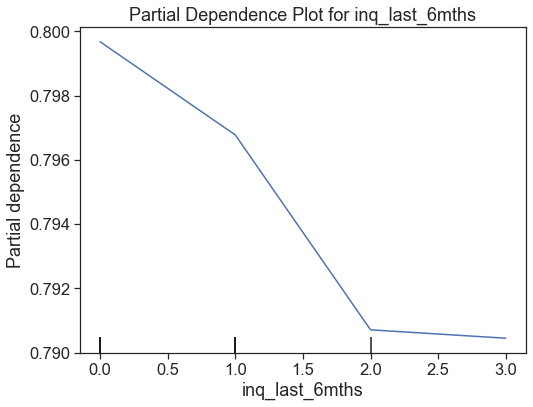

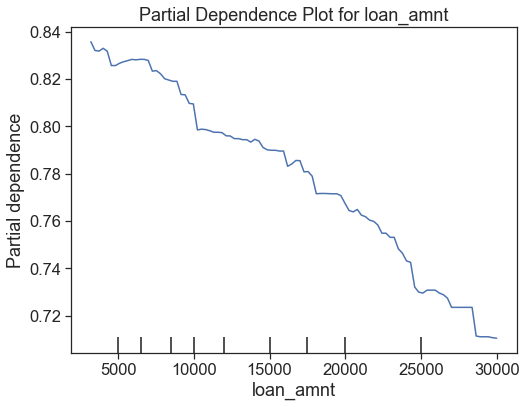

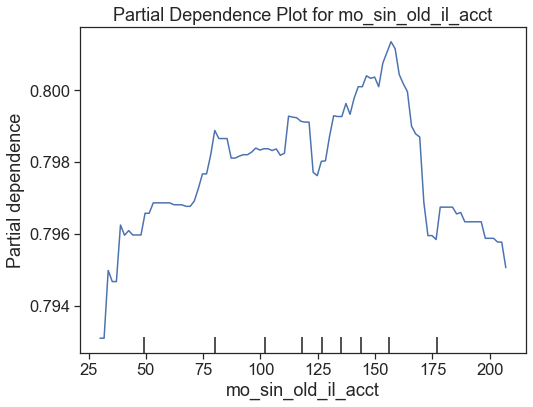

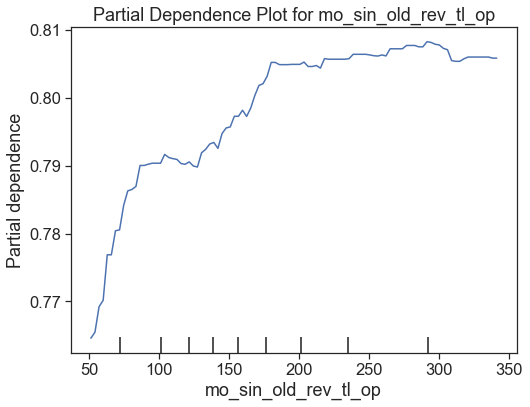

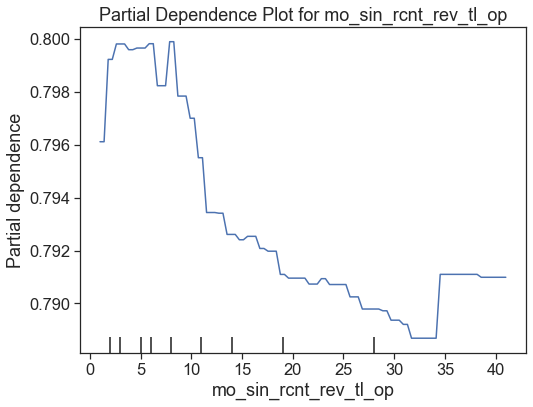

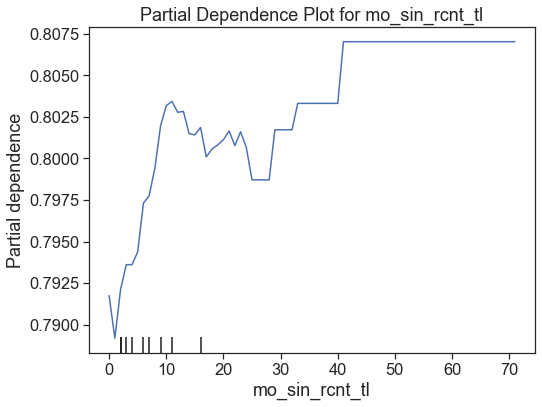

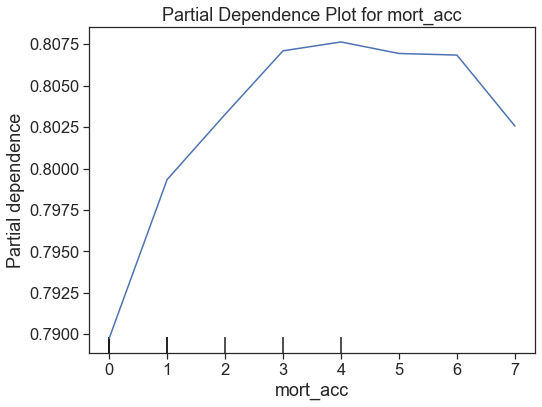

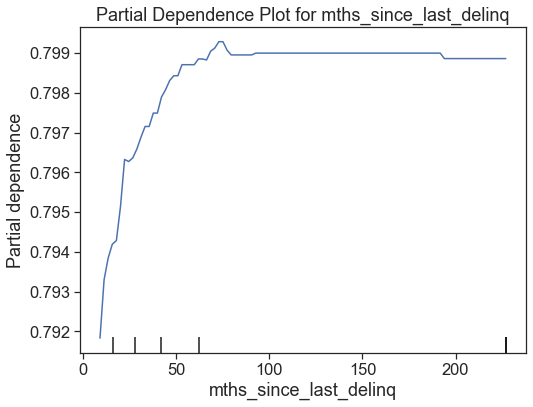

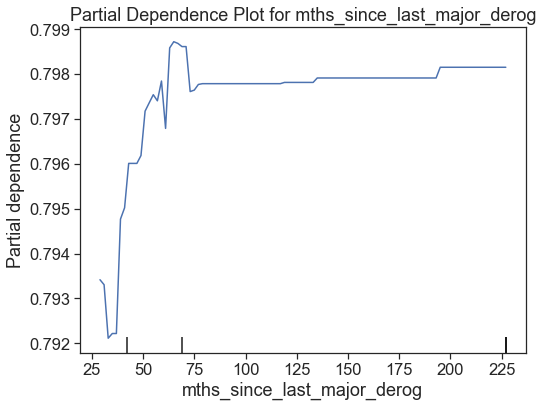

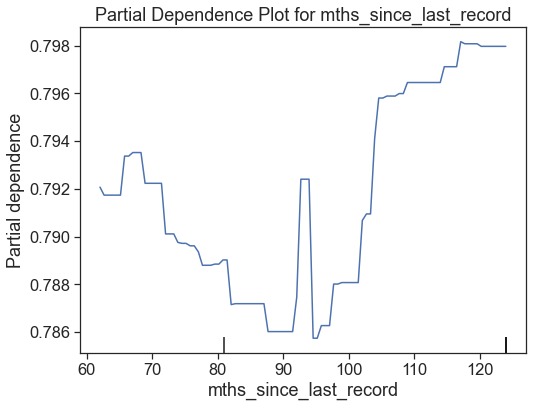

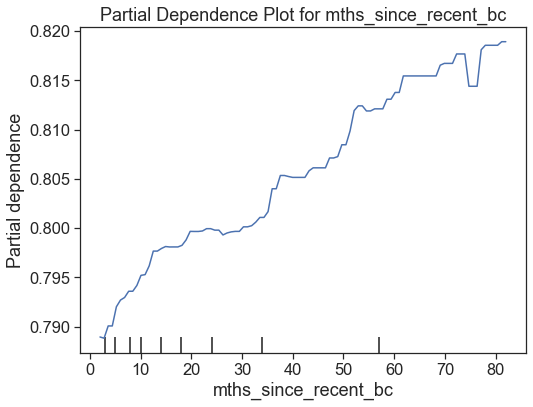

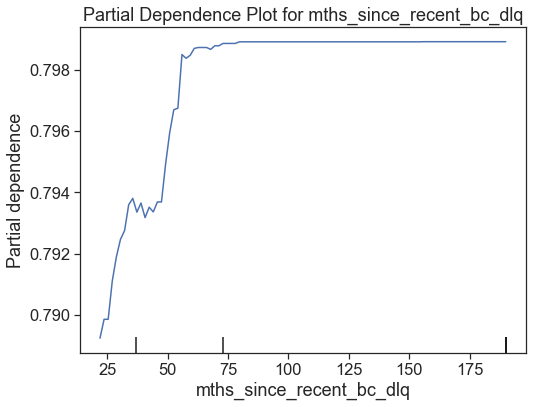

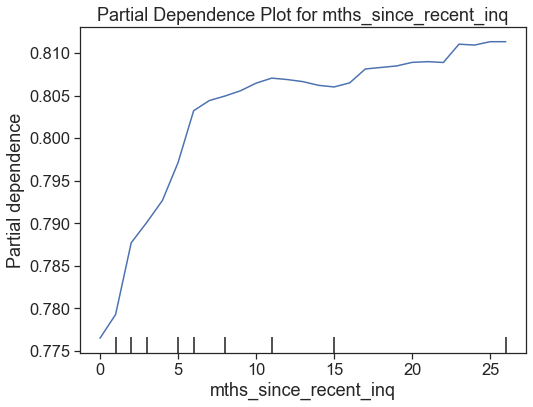

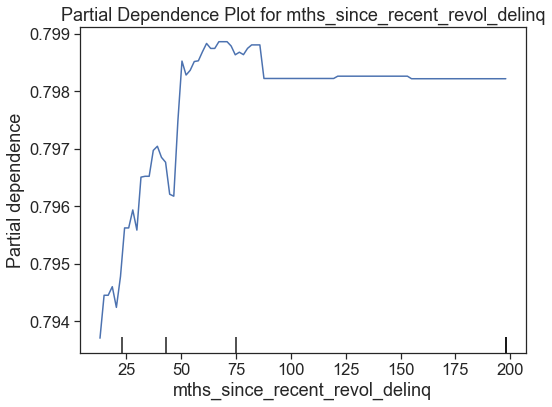

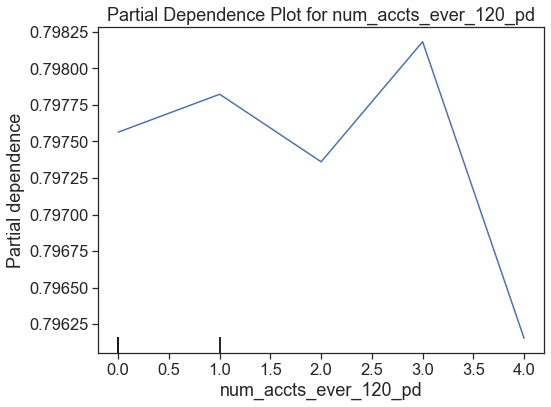

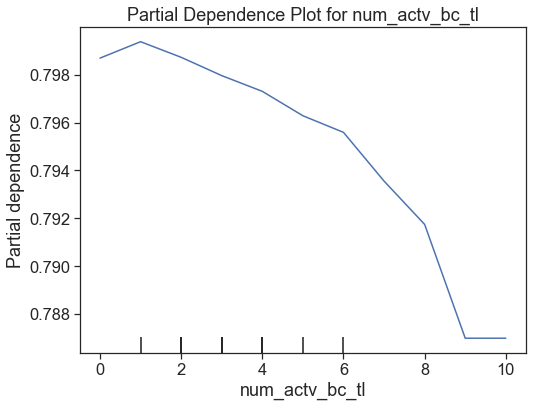

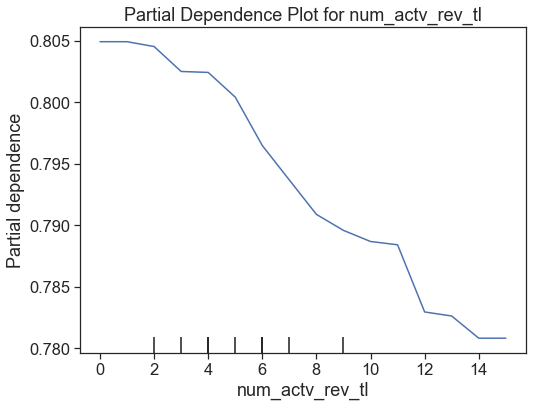

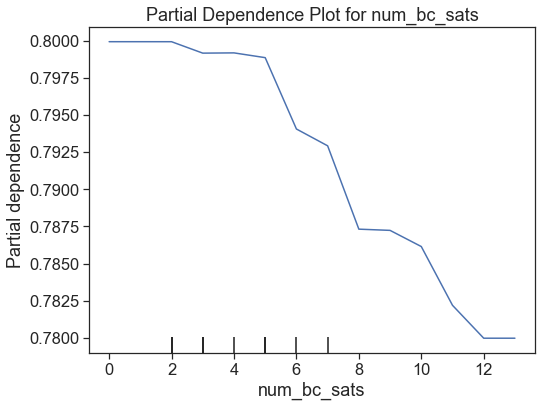

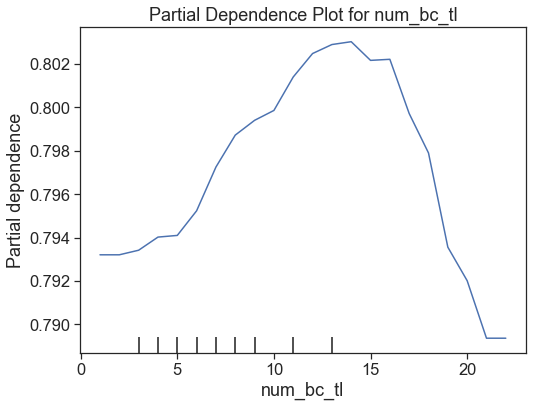

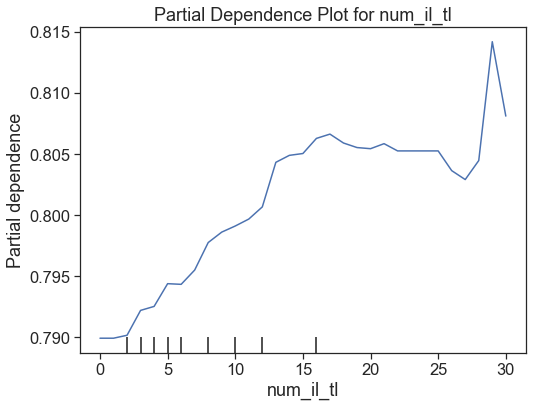

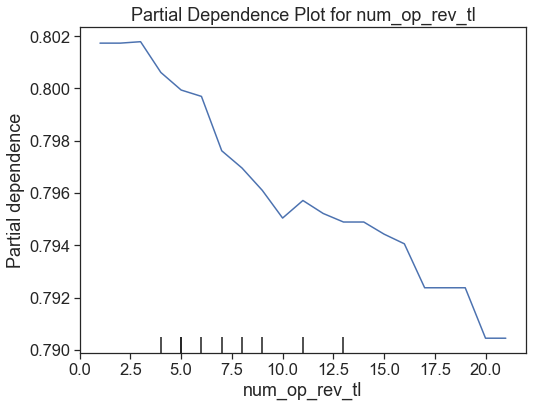

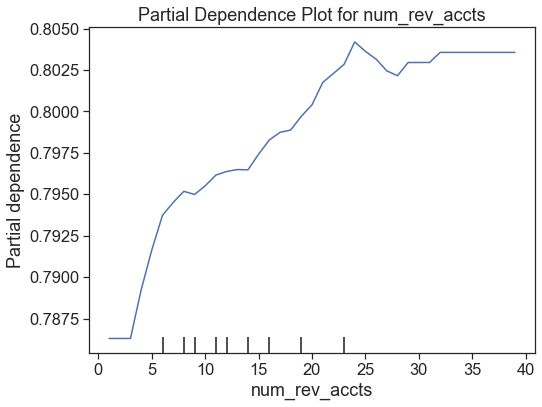

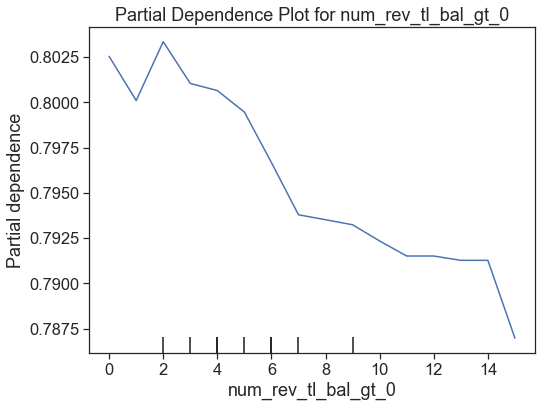

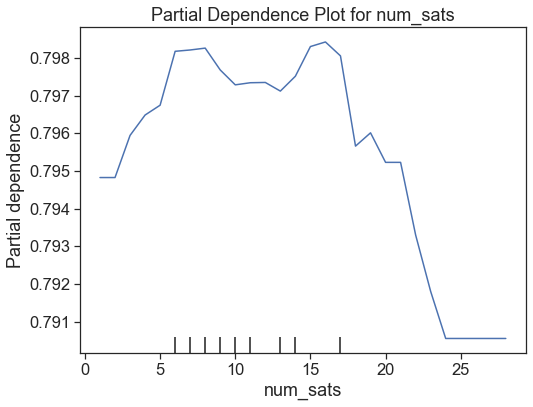

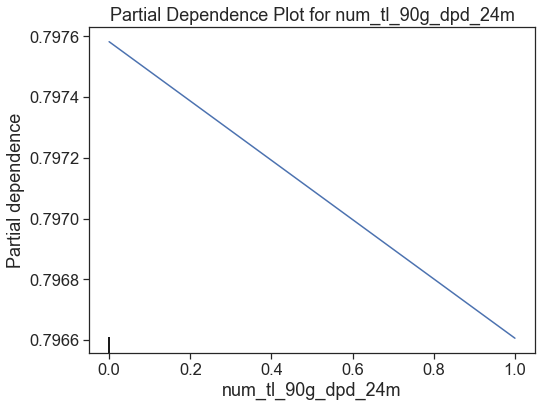

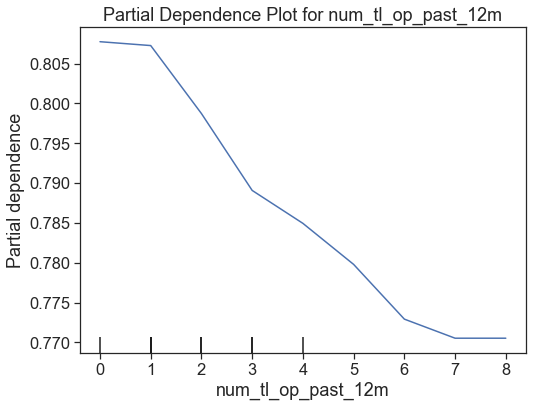

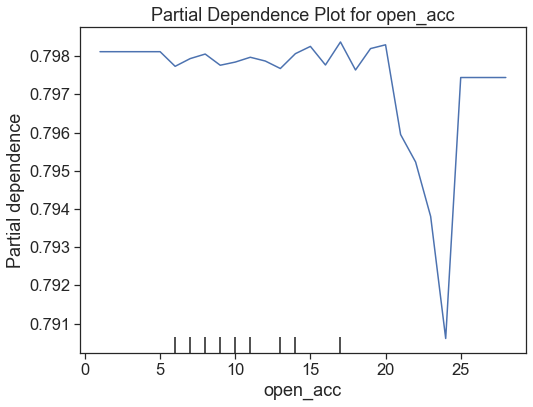

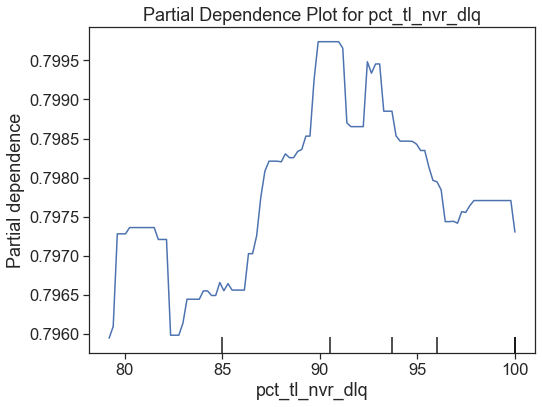

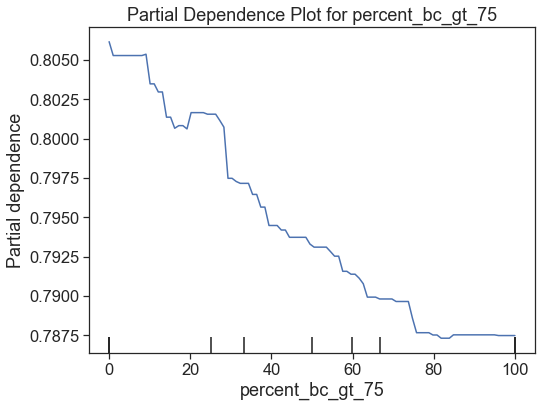

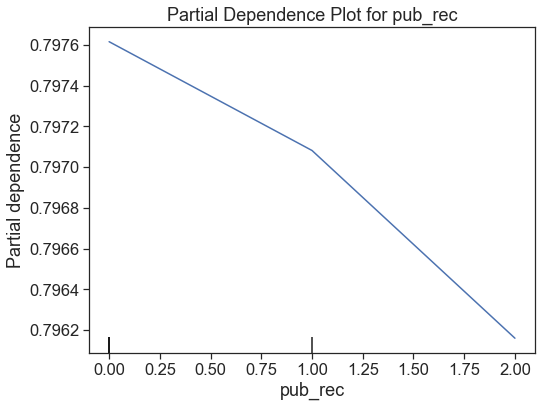

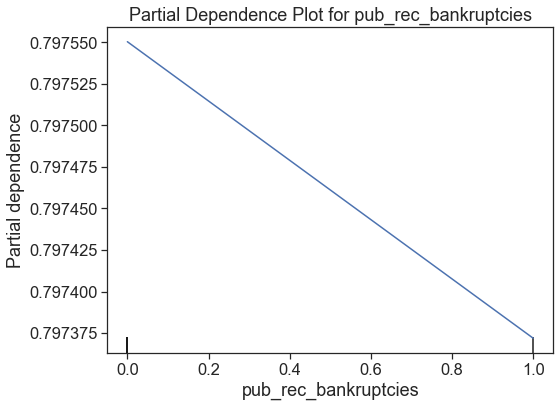

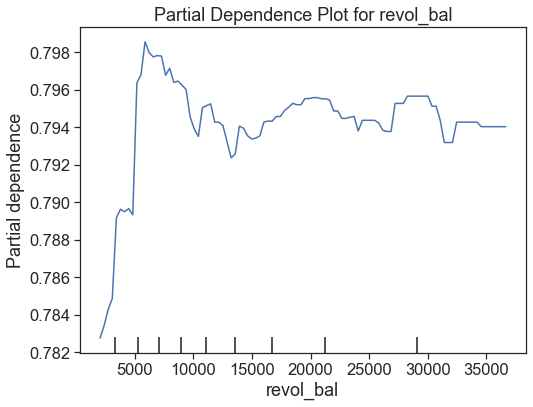

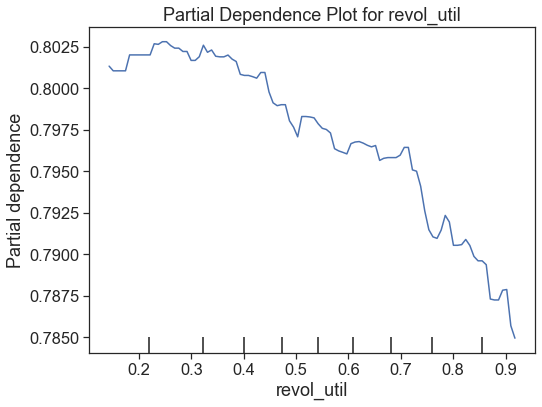

ValueError: percentiles are too close to each other, unable to build the grid. Please choose percentiles that are further apart.

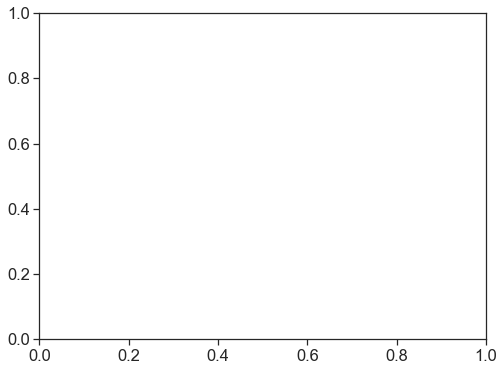

In [62]:
from sklearn.inspection import PartialDependenceDisplay
for feature in X.columns:
    plt.figure(figsize=(8, 6))
    PartialDependenceDisplay.from_estimator(
        estimator=lgbm3,
        X=X_train,
        features=[feature],
        kind="average",  # Change to 'both' to include ICE curves
        ax=plt.gca(),
    )
    plt.title(f"Partial Dependence Plot for {feature}")
    plt.show()